In [78]:
#############################################################################################
## Function to plot Water Year hydrographs using Aquarius-formatted dischage (Q) data [cms] #
###Also plots snowpack depths from CoCoRAHs or NOAA daily summary datasets ##################
## Megan E Duffy, 2026-01-14 ################################################################
## last updated 2026-01-14 ##################################################################

# Snowpack depth data accessed using NCEI NOAA data portal:
# https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND%3AUSW00014742/detail%3Bjsessionid%3DA836DA7E448FD395DEC9384AA3AA78DE

### Set working directory ###

### Import libraries ###
library(readr)
library(dplyr)
library(lubridate)
library(ggplot2)
library(patchwork)

### Define function to plot hydrograph 
# Inputs: discharge file (csv), stream name (Wade, Hungerford, or Potash), start datetime, end datetime
# Output: plot of stream discharge timeseries with stream title and time range as plot title

plot_discharge <- function(
  file,
  stream_name,
  start_datetime,
  end_datetime,
  y_max = NULL,
  y_snow_max = NULL,
  output_dir = NULL,
  text_scale = 1,
  snowpack_file = NULL,
  snowpack_datetime_col = NULL,
  snowpack_depth_col = NULL
) {
  # --------------------------------------------------------------------
  # Read discharge data
  # --------------------------------------------------------------------
  discharge_df <- read_csv(
    file,
    comment = "#",
    show_col_types = FALSE
  ) |>
    mutate(
      datetime = ymd_hms(`Timestamp (UTC-04:00)`)
    ) |>
    filter(
      datetime >= ymd_hms(start_datetime),
      datetime <= ymd_hms(end_datetime)
    )

  if (nrow(discharge_df) == 0) {
    stop("No discharge data found in the specified time range.")
  }

  base_text_size <- 12 * text_scale

  # --------------------------------------------------------------------
  # Discharge plot
  # --------------------------------------------------------------------
  discharge_plot <- discharge_df |>
    ggplot(aes(x = datetime, y = Value)) +
    geom_line(color = "steelblue", linewidth = 0.7) +
    labs(
      x = NULL,
      y = expression("Discharge (" * m^3 * "/s)")
    ) +
    theme_minimal(base_size = base_text_size)

  if (!is.null(y_max)) {
    discharge_plot <- discharge_plot +
      coord_cartesian(ylim = c(0, y_max))
  }

# --------------------------------------------------------------------
# Optional snowpack plot
# --------------------------------------------------------------------
if (!is.null(snowpack_file)) {
  if (is.null(snowpack_datetime_col) || is.null(snowpack_depth_col)) {
    stop("Snowpack datetime and depth columns must be specified.")
  }

  start_date <- as.Date(start_datetime)
  end_date <- as.Date(end_datetime)

  snowpack_df <- read_csv(
    snowpack_file,
    show_col_types = FALSE
  ) |>
    mutate(
      snow_datetime = as.Date(.data[[snowpack_datetime_col]])
    ) |>
    filter(
      snow_datetime >= start_date,
      snow_datetime <= end_date
    )

  if (nrow(snowpack_df) == 0) {
    stop("No snowpack data found in the specified time range.")
  }

  snowpack_plot <- snowpack_df |>
    ggplot(
      aes(
        x = snow_datetime,
        y = .data[[snowpack_depth_col]]
      )
    ) +
    geom_step(color = "gray30", linewidth = 0.7) +
    labs(
      x = NULL,
      y = "Snow depth (cm)"
    ) +
    theme_minimal(base_size = base_text_size)

  if (!is.null(y_snow_max)) {
    snowpack_plot <- snowpack_plot +
      coord_cartesian(ylim = c(0, y_snow_max))
  }

  final_plot <-
    snowpack_plot /
    discharge_plot +
    plot_layout(heights = c(1, 2)) +
    plot_annotation(
      title = paste0(
        stream_name,
        ": snowpack depth and Q (",
        start_datetime,
        " to ",
        end_datetime,
        ")"
      ),
      theme = theme(
        plot.title = element_text(
          hjust = 0.5,
          margin = margin(b = 8)
        )
      )
    )
} else {
    # Discharge only ----------------------------------------------------
    final_plot <- discharge_plot +
      labs(
        title = paste0(
          stream_name,
          " discharge (",
          start_datetime,
          " to ",
          end_datetime,
          ")"
        ),
        x = "Date"
      )
  }

  # --------------------------------------------------------------------
  # Save output if requested
  # --------------------------------------------------------------------
  if (!is.null(output_dir)) {
    if (!dir.exists(output_dir)) {
      stop("The specified output directory does not exist.")
    }

    file_name <- paste(
      gsub(" ", "_", stream_name),
      format(ymd_hms(start_datetime), "%Y%m%d"),
      format(ymd_hms(end_datetime), "%Y%m%d"),
      "hydrograph.jpg",
      sep = "_"
    )

    ggsave(
      filename = file.path(output_dir, file_name),
      plot = final_plot,
      width = 12,
      height = 6,
      dpi = 300
    )
  }

  final_plot
}

New names:
• `` -> `...1`


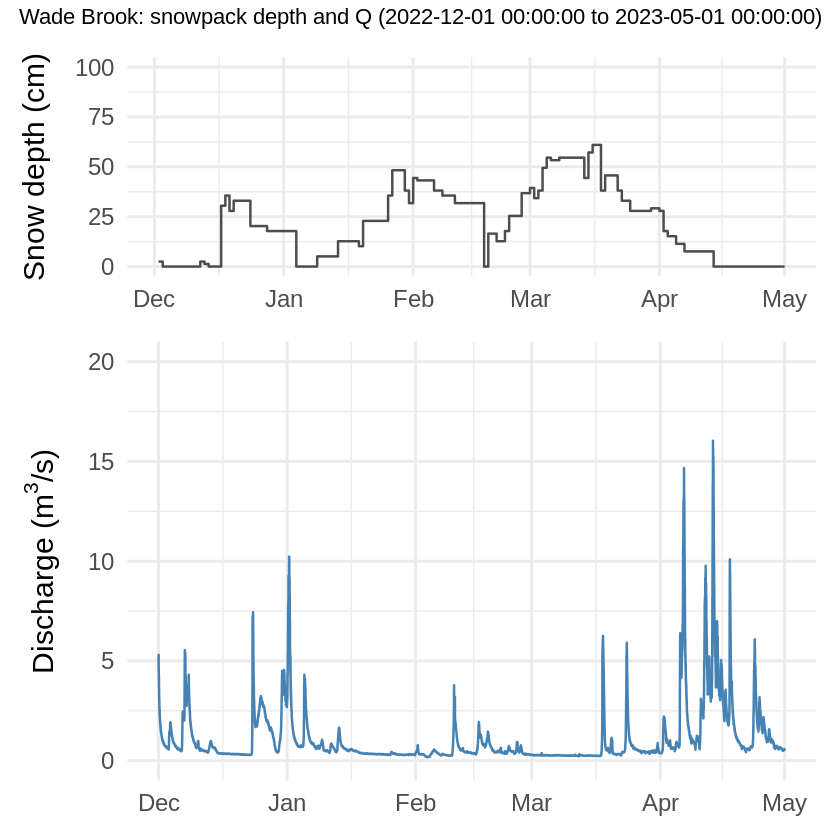

In [85]:
# Set working directory
setwd("~/OneDrive/git-repos/LCBP-interannual-EMMAs/Data//StreamSensor_data/")

plot_discharge(
  file = "Discharge.Discharge_cms@Wade_Brook.20221001.csv",
  stream_name = "Wade Brook",
  start_datetime = "2022-12-01 00:00:00",
  end_datetime = "2023-05-01 00:00:00",
  y_max = 20,
  y_snow_max = 100,
  text_scale = 1.5,
  snowpack_file = "~/OneDrive/git-repos/LCBP-interannual-EMMAs/Data/Met_data/Wade_cocorahs-vt-fr-30-20221115-20250414.csv",
  snowpack_datetime_col = "datetime",
  snowpack_depth_col = "snowpack_cm",
  output_dir = "~/OneDrive/git-repos/LCBP-interannual-EMMAs/Output/Hydrographs/"
)

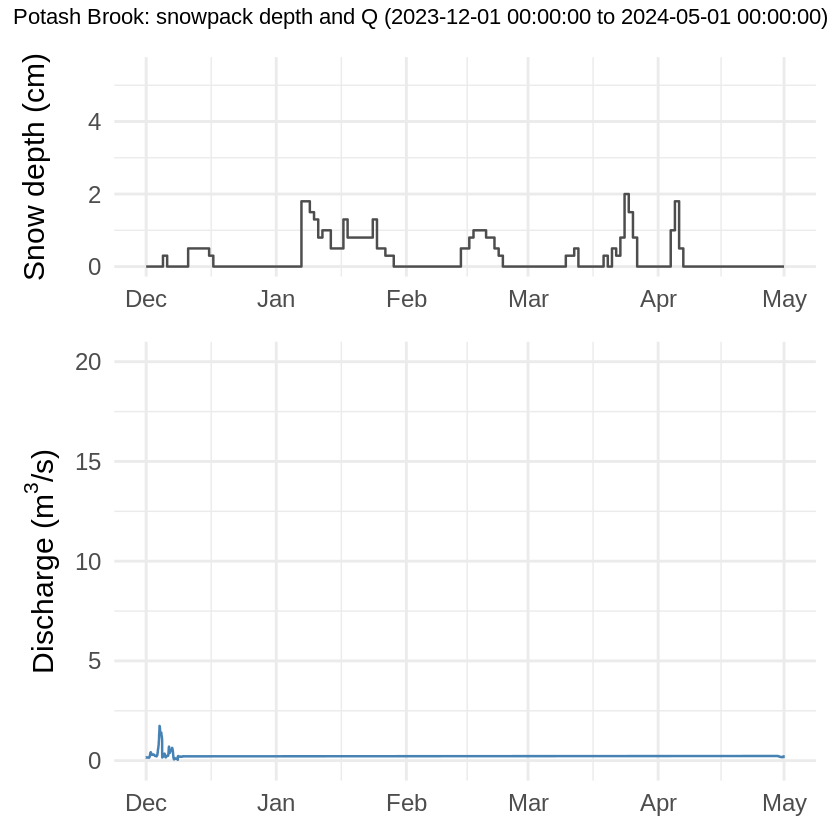

In [90]:
# Set working directory
setwd("~/OneDrive/git-repos/LCBP-interannual-EMMAs/Data/StreamSensor_data/")

plot_discharge(
  file = "Discharge.Discharge_Updated@Potash_Brook.20221001.csv",
  stream_name = "Potash Brook",
  start_datetime = "2023-12-01 00:00:00",
  end_datetime = "2024-05-01 00:00:00",
  y_max = 20,
  y_snow_max = 5.5,
  text_scale = 1.5,
  snowpack_file = "~/OneDrive/git-repos/LCBP-interannual-EMMAs/Data/Met_data/Potash_KBTV-GHCN-Daily-WY22-WY25.csv",
  snowpack_datetime_col = "DATE",
  snowpack_depth_col = "snowpack_cm",
  output_dir = "~/OneDrive/git-repos/LCBP-interannual-EMMAs/Output/Hydrographs/"
)